<a href="https://colab.research.google.com/github/atbolsh/BNN_order_statistics/blob/master/MnistQuantizedAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code for this, obviously, is half-ripped from the larq tutorial, and half from the keras intro to autoencoders.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [ ]:
latent_dim = 32 

class NormalAutoencoder(Model):
  def __init__(self, latent_dim):
    super(NormalAutoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(400, activation = 'relu'),
      layers.Dense(200, activation = 'relu'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(200, activation='relu'),
      layers.Dense(400, activation='relu'),
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

nauto = NormalAutoencoder(latent_dim)

In [ ]:
nauto.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
nauto.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 0.0369 - val_loss: 0.0113
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0107 - val_loss: 0.0090
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0087 - val_loss: 0.0081
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0070 - val_loss: 0.0073
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.006

In [ ]:
encoded_imgs = nauto.encoder(x_test).numpy()
decoded_imgs = nauto.decoder(encoded_imgs).numpy()

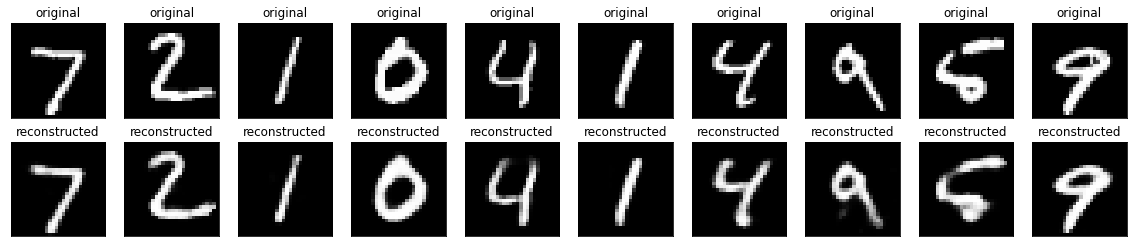

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Beautiful. Now, on to the main show.

In [ ]:
pip install larq

     |████████████████████████████████| 71kB 6.7MB/s 
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=7921d8687bf8da845cfa647f21b096192a9b0c9bbe2020ad9a97521f99f68e2d
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables


In [ ]:
import larq as lq

In [ ]:
latent_dim = 128
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip", use_bias=False)


class QuantizedAutoencoder(Model):
  def __init__(self, latent_dim):
    super(QuantizedAutoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      lq.layers.QuantDense(512, kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,), # Best practices suggests not touching first / last layers.
      layers.BatchNormalization(scale=False),
      lq.layers.QuantDense(256, **kwargs),
      layers.BatchNormalization(scale=False),
      lq.layers.QuantDense(latent_dim, **kwargs), # No way is it a good idea to only have binary latents.
      layers.BatchNormalization(scale=False),
    ])
    self.decoder = tf.keras.Sequential([
      lq.layers.QuantDense(256, kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,), # Again, can't mess with the inputs, which are floats
      layers.BatchNormalization(scale=False),
      lq.layers.QuantDense(512, **kwargs),
      layers.BatchNormalization(scale=False),
      lq.layers.QuantDense(784, **kwargs),
      layers.BatchNormalization(scale=False), # Output is a large int; to get gray outputs, I need to normalize first. (kind of defeats the purpos. Oh well.)
      layers.Activation('sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

qauto = QuantizedAutoencoder(latent_dim)

In [ ]:
qauto.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanSquaredError())

In [ ]:
qauto.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.1670 - val_loss: 0.0647
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0578 - val_loss: 0.0360
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0357 - val_loss: 0.0306
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0318 - val_loss: 0.0289
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0304 - val_loss: 0.0282
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0298 - val_loss: 0.0278
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0296 - val_loss: 0.0277
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0294 - val_loss: 0.0274
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0292 - val_loss: 0.0273
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.029

In [ ]:
encoded_imgs = qauto.encoder(x_test).numpy()
decoded_imgs = qauto.decoder(encoded_imgs).numpy()

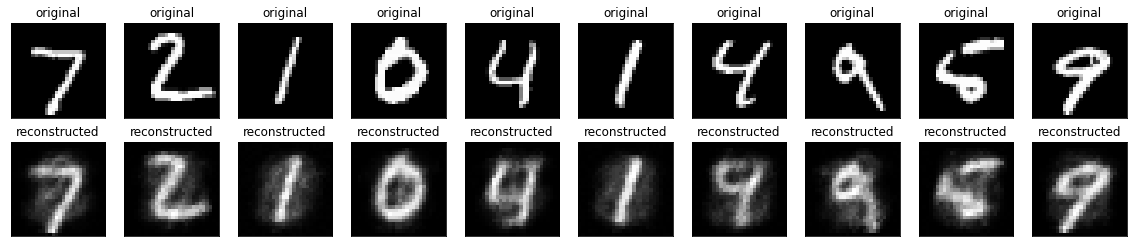

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# So far, so good. Very interesting results. But how would such a system perform on fashionMNIST, which has so many more shade of grey?

In [ ]:
fqauto = QuantizedAutoencoder(128)

In [ ]:
(y_train, _), (y_test, _) = fashion_mnist.load_data()

y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

print (y_train.shape)
print (y_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [ ]:
fqauto.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanSquaredError())

In [ ]:
fqauto.fit(y_train, y_train,
                epochs=10,
                shuffle=True,
                validation_data=(y_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.0965 - val_loss: 0.0412
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0392 - val_loss: 0.0295
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0308 - val_loss: 0.0277
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0294 - val_loss: 0.0267
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0289 - val_loss: 0.0263
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0285 - val_loss: 0.0263
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0283 - val_loss: 0.0259
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0282 - val_loss: 0.0259
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0281 - val_loss: 0.0260
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.028

In [ ]:
encoded_imgs = fqauto.encoder(y_test).numpy()
decoded_imgs = fqauto.decoder(encoded_imgs).numpy()

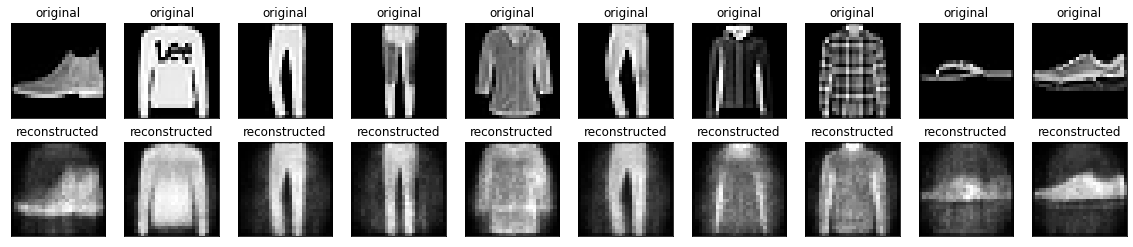

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(y_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Conclusion: the batchNorms are a little weird and artificial. Much better would be proper pseudogradient normalization to prevent this nonsense.
# After all, that's the only reason it gets thrown off later; the intermediate activations seem WAY too large, since they're integers of a size ~ matrix input size.
# A fun thing to try would be to write a custom quantizer that fixes this issue, then pinging PlumeAI

In [ ]:
# More importantly, the entire structure of the autoencoder needs to change.
# The real limiter, after all ISN'T the 128 floats (or even 32 floats) in the middle; it's the 256 binary activations.
# So, just have ONE ver large binary layer in the middle. And that's it; that's the tweet.

In [ ]:
latent_dim = 512+256 # This gets roughly the correct size of network as above.
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip", use_bias=False)


class TrueQuantizedAutoencoder(Model):
  def __init__(self, latent_dim):
    super(TrueQuantizedAutoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      lq.layers.QuantDense(latent_dim, kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,), # Best practices suggests not touching first / last layers.
      layers.BatchNormalization(scale=False)#, momentum=0.9),
    ])
    self.decoder = tf.keras.Sequential([
      lq.layers.QuantDense(784, **kwargs),
      layers.BatchNormalization(scale=False),#, momentum=0.9), # Output is a large int; to get gray outputs, I need to normalize first. (kind of defeats the purpos. Oh well.)
      layers.Activation('sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

qauto2 = TrueQuantizedAutoencoder(latent_dim)

In [ ]:
qauto2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanSquaredError())

In [ ]:
qauto2.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1538 - val_loss: 0.0538
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0448 - val_loss: 0.0265
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0263 - val_loss: 0.0218
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0228 - val_loss: 0.0206
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0217 - val_loss: 0.0204
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0215 - val_loss: 0.0202
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0213 - val_loss: 0.0200
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0212 - val_loss: 0.0199
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0212 - val_loss: 0.0199
Epoch 10/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.021

In [ ]:
encoded_imgs = qauto2.encoder(x_test).numpy()
decoded_imgs = qauto2.decoder(encoded_imgs).numpy()

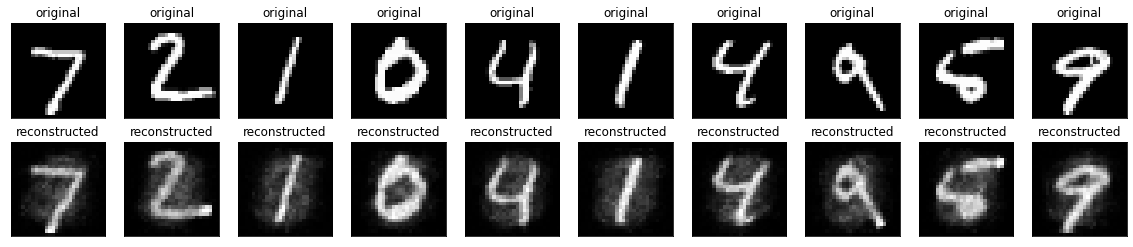

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show() # No better than old momentum settings.

In [ ]:
fqauto2 = TrueQuantizedAutoencoder(latent_dim)

In [ ]:
fqauto2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanSquaredError())

In [ ]:
fqauto2.fit(y_train, y_train,
                epochs=10,
                shuffle=True,
                validation_data=(y_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0865 - val_loss: 0.0332
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0306 - val_loss: 0.0240
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0234 - val_loss: 0.0222
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0222 - val_loss: 0.0223
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0219 - val_loss: 0.0211
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0218 - val_loss: 0.0212
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0218 - val_loss: 0.0216
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0217 - val_loss: 0.0212
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0217 - val_loss: 0.0208
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.021

In [ ]:
encoded_imgs = fqauto2.encoder(y_test).numpy()
decoded_imgs = fqauto2.decoder(encoded_imgs).numpy()

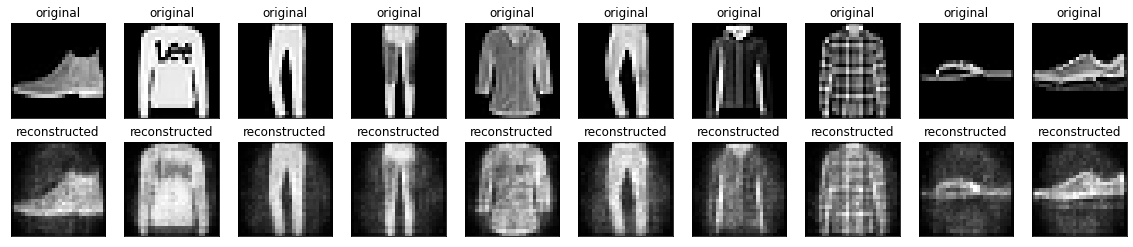

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(y_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Very well. And it does the same thing as before, too; it reduces the float system to a lower dimension, before recovering it.
# NEXT STEP: Design a custom either activation or pseudogradient that correctly quantizes everything.

In [ ]:
# OUt of curiousity, let's retry the above with 256 instead of 512+256
# Not horrible. Loss is creeping up as I cut dims, though . . .
# 4 bits is where MNIST digits really become unrecognizable (though 8 and 16 bits weren't pretty, either.)

In [ ]:
# fmnist gets ugly by 32 bits, and it's hard to tell what's what.
# Very ugly, hard to tell what's what by 16 bits

In [ ]:
# This one should be able to replace the BatchNorms above, by putting the pseudogradient into a reasonable range.

class SingleRescaling(Model):
  def __init__(self, scale):
    super(SingleRescaling, self).__init__()
    self.scale = scale

  def call(self, x):
    return (x / self.scale)

In [ ]:
srTest = SingleRescaling(0.2)

In [ ]:
srTest(np.array([1., 2., 3., 4.]))

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 5., 10., 15., 20.], dtype=float32)>

In [ ]:
# Good, now let's try to redefine the autoencoder class above.

In [ ]:
latent_dim = 512+256 # This gets roughly the correct size of network as above.
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip", use_bias=False)


class NewQuantizedAutoencoder(Model):
  def __init__(self, latent_dim):
    super(NewQuantizedAutoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      lq.layers.QuantDense(latent_dim, kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,), # Best practices suggests not touching first / last layers.
      SingleRescaling(np.sqrt(latent_dim)), # For the gradients, nothing more.
    ])
    self.decoder = tf.keras.Sequential([
      lq.layers.QuantDense(784, **kwargs),
      SingleRescaling(np.sqrt(784)),
      layers.Activation('sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [ ]:
qauto = NewQuantizedAutoencoder(latent_dim)

In [ ]:
qauto.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanSquaredError())

In [ ]:
qauto.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0307 - val_loss: 0.0121
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0121 - val_loss: 0.0117
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0118 - val_loss: 0.0117
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0118 - val_loss: 0.0117
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0117 - val_loss: 0.0116
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0117 - val_loss: 0.0116
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0117 - val_loss: 0.0117
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.011

In [ ]:
encoded_imgs = qauto.encoder(x_test).numpy()
decoded_imgs = qauto.decoder(encoded_imgs).numpy()

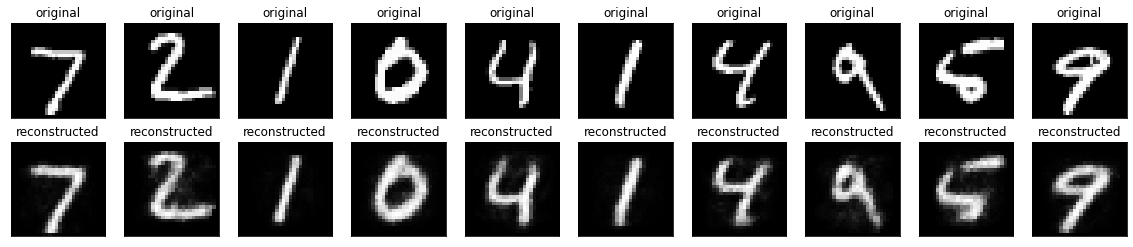

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
fqauto = NewQuantizedAutoencoder(latent_dim)

In [ ]:
fqauto.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanSquaredError())

In [ ]:
fqauto.fit(y_train, y_train,
                epochs=10,
                shuffle=True,
                validation_data=(y_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0395 - val_loss: 0.0234
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0234 - val_loss: 0.0222
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0222 - val_loss: 0.0234
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0219 - val_loss: 0.0230
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0218 - val_loss: 0.0215
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0215 - val_loss: 0.0225
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0214 - val_loss: 0.0212
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0212 - val_loss: 0.0210
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0212 - val_loss: 0.0214
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.021

In [ ]:
encoded_imgs = fqauto.encoder(y_test).numpy()
decoded_imgs = fqauto.decoder(encoded_imgs).numpy()

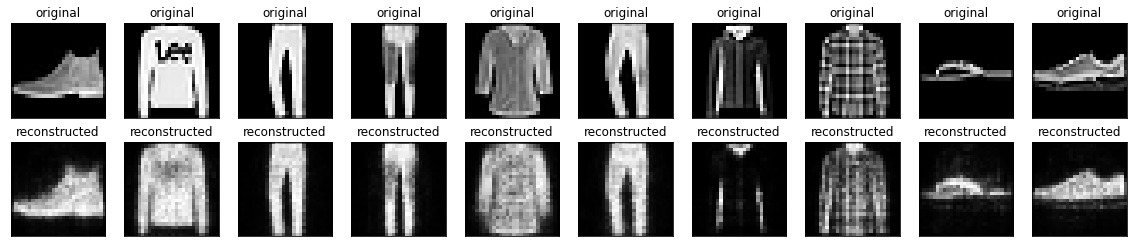

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(y_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# So far, so good. Now, redo with a custom quantizer.

# But then: play with bop.

# First, let's see if a self-correcting quantizer - the swish sign - fixes our issues. Because it might be getting stuck.

In [ ]:
latent_dim = 512+256 # This gets roughly the correct size of network as above.
kwargs = dict(input_quantizer=lq.quantizers.SwishSign(),
              kernel_quantizer=lq.quantizers.SwishSign(),
              kernel_constraint="weight_clip", use_bias=False)


class SwishQuantizedAutoencoder(Model):
  def __init__(self, latent_dim):
    super(SwishQuantizedAutoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      lq.layers.QuantDense(latent_dim, kernel_quantizer=lq.quantizers.SwishSign(),
                                kernel_constraint="weight_clip",
                                use_bias=False,), # Best practices suggests not touching first / last layers.
      SingleRescaling(np.sqrt(latent_dim)), # For the gradients, nothing more.
    ])
    self.decoder = tf.keras.Sequential([
      lq.layers.QuantDense(784, **kwargs),
      SingleRescaling(np.sqrt(784)),
      layers.Activation('sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [ ]:
qauto = SwishQuantizedAutoencoder(latent_dim)

In [ ]:
qauto.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanSquaredError())

In [ ]:
qauto.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 0.0274 - val_loss: 0.0121
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0119 - val_loss: 0.0113
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0112 - val_loss: 0.0110
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0110 - val_loss: 0.0111
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.011

In [ ]:
encoded_imgs = qauto.encoder(x_test).numpy()
decoded_imgs = qauto.decoder(encoded_imgs).numpy()

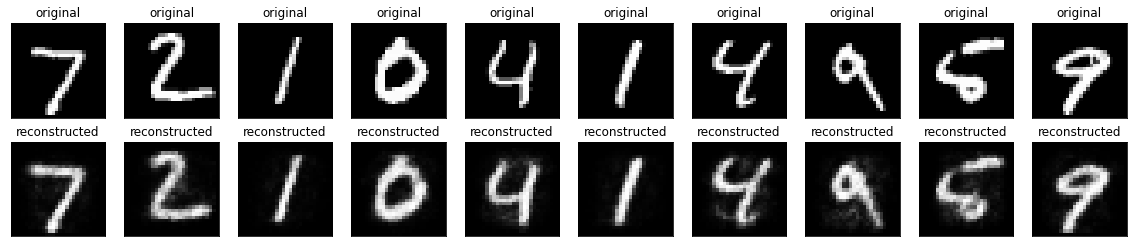

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# No help I can see. What about fqauto?

In [ ]:
fqauto = SwishQuantizedAutoencoder(latent_dim)

In [ ]:
fqauto.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanSquaredError())

In [ ]:
fqauto.fit(y_train, y_train,
                epochs=10,
                shuffle=True,
                validation_data=(y_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0327 - val_loss: 0.0203
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0195 - val_loss: 0.0187
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0186 - val_loss: 0.0180
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0180 - val_loss: 0.0178
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0174 - val_loss: 0.0170
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0171 - val_loss: 0.0207
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0170 - val_loss: 0.0173
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0168 - val_loss: 0.0167
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0167 - val_loss: 0.0171
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.016

In [ ]:
encoded_imgs = fqauto.encoder(y_test).numpy()
decoded_imgs = fqauto.decoder(encoded_imgs).numpy()

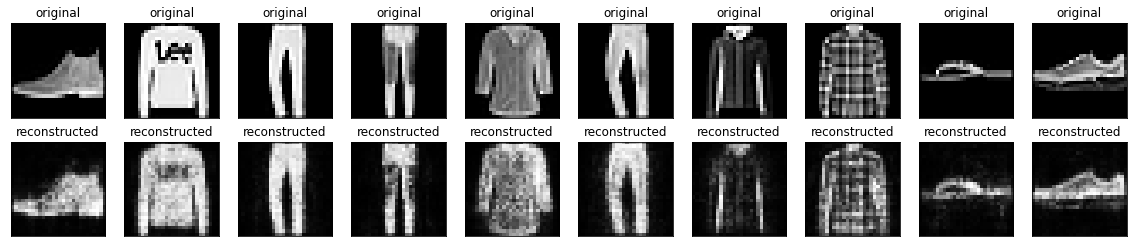

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(y_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Lower loss AND sharper! Cool!
# Possibly within expected range, though; don't make too big a deal out of it.
# Let's see if we can make the scale-aware quantizer work well.

In [ ]:
#def RescaledGradient(scale):
#  @tf.custom_gradient
#  def gradient(x):
#    x1, grad1 = lq.quantizers.SteSign()(x)
#
#    return x1 / self.scale, lambda y : grad1(y) / self.scale
#
#  return gradient

class RescaledGradient:
  def __init__(self, scale):
    self.scale = scale
    self.original = lq.quantizers.SteSign()

  @tf.custom_gradient
  def __call__(self, x):
    x1, grad1 = self.original(x)

    return x1 / self.scale, lambda y : grad1(y) / self.scale

# OK, that didn't work well, let's try two small, custom methods.

original = lq.quantizers.SteSign()
a = np.sqrt(512 + 256)
b = np.sqrt(784)

@tf.custom_gradient
def custom1(x):
  x1, grad1 = original(x)

  return x / a, lambda y : grad1(y) / a

@tf.custom_gradient
def custom2(x):
  x1, grad1 = original(x)

  return x / b, lambda y : grad1(y) / b


In [ ]:
latent_dim = 512+256 # This gets roughly the correct size of network as above.
kwargs = dict(input_quantizer=lq.quantizers.SwishSign(),
              kernel_quantizer=lq.quantizers.SwishSign(),
              kernel_constraint="weight_clip", use_bias=False)



class CustomQuantizedAutoencoder(Model):
  def __init__(self, latent_dim):
    super(CustomQuantizedAutoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      lq.layers.QuantDense(latent_dim, kernel_quantizer=custom1,
                                kernel_constraint="weight_clip",
                                use_bias=False,), # Best practices suggests not touching first / last layers.
    ])
    self.decoder = tf.keras.Sequential([
      lq.layers.QuantDense(784, input_quantizer=custom2,
              kernel_quantizer=custom2,
              kernel_constraint="weight_clip", use_bias=False),
      layers.Activation('sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [ ]:
qauto = CustomQuantizedAutoencoder(latent_dim)

In [ ]:
qauto.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanSquaredError())

In [ ]:
qauto.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10


TypeError: ignored

In [ ]:
# Ok, many versions of the custom quantizer didn't work.
# I'm not learning anything with this; leave it for now. Test bop, make tomorrow plans.